In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from haversine import haversine, Unit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from category_encoders.target_encoder import TargetEncoder
import interpolation
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from xgboost import plot_tree

In [2]:
filled_1850 = pd.read_csv("../data/dwelling_filled_sum_1850_mn.csv")
census_1880 = pd.read_csv("../data/census_1880_mn_blocks.csv")

/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
filled_1850.rename(columns = {"CENSUS_WARD_NUM":"WARD_NUM", "CENSUS_SERIALP":"CENSUS_SERIALB", "BLOCK_NUM":"block_num"}, inplace = True)

In [4]:
dwellings_1850, dwellings_1880, census_1850_model, census_1880_model = interpolation.sequence_datasets(filled_1850, census_1880)

In [5]:
census_1850_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 514718 entries, 0 to 514717
Data columns (total 37 columns):
block_num                  261427 non-null float64
CD_ADDRESS                 261427 non-null object
CD_X                       261427 non-null float64
CD_Y                       261427 non-null float64
CENSUS_AGE                 514718 non-null int64
CENSUS_CITY                514718 non-null int64
CENSUS_DWELLING_NUM        514718 non-null float64
CENSUS_DWELLING_SEQ        513135 non-null float64
CENSUS_DWELLING_SIZE       514718 non-null int64
CENSUS_GEOG                514006 non-null object
CENSUS_HH_NUM              514718 non-null int64
CENSUS_ID                  12315 non-null object
CENSUS_IMPREL              514718 non-null int64
CENSUS_INDEX               514718 non-null int64
CENSUS_IPUMS_UID           514718 non-null object
CENSUS_LABFORCE            514718 non-null int64
CENSUS_LINE                514718 non-null int64
CENSUS_MARST               514718 non-null 

In [6]:
cols = ["street_name", "sequence_id", "WARD_NUM", "CENSUS_SERIALB", "block_num"]
train_X, train_y, test_1880_X, test_1880_y, test_1850_X, test_1850_y = interpolation.create_train_test_data(census_1880_model, census_1850_model, cols)

In [7]:
model_gboost = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB","WARD_NUM","street_name", "sequence_id", "block_num"])),
                         ('regressor', XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1,
                max_depth = 3, n_estimators = 1000, colsample_bytree = 0.5, alpha = 1))])

In [8]:
model_gboost.fit(train_X, train_y)
print("Training Score:", model_gboost.score(train_X, train_y))
print("1880 Test Score:", model_gboost.score(test_1880_X, test_1880_y))
print("1850 Test Score:", model_gboost.score(test_1850_X, test_1850_y))

Training Score: 0.9908513263003917
1880 Test Score: 0.9700777158301085
1850 Test Score: 0.9576060742752103


In [9]:
#Let's try predicting on a dwelling level
print("1850 Dwelling Score:", model_gboost.score(dwellings_1850.dropna(subset=["house_number"]).loc[:, cols], dwellings_1850.dropna(subset=["house_number"]).loc[:,"house_number"]))

1850 Dwelling Score: 0.9717477554147982


In [10]:
dwellings_1850["predicted_house_number"] = model_gboost.predict(dwellings_1850.loc[:, cols])

In [11]:
dwellings_1850.head(30)

,WARD_NUM,CENSUS_DWELLING_NUM,block_num,CD_ADDRESS,CD_X,CD_Y,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,...,next_x,next_y,dist,num_between,sequence_id,sequence_len,sequence_order,house_number,street_name,predicted_house_number
0,1.0,1.0,3794.0,37 South,-74.008250,40.703128,49.0,4610.0,1.0,84.0,...,-74.007679,40.707284,0.088400,3.0,5.0,6.0,3.0,37.0,South,13.456789
1,1.0,4.0,713.0,76 Liberty,-74.007679,40.707284,23.0,4610.0,4.0,1.0,...,-74.009067,40.707572,0.096077,2.0,5.0,6.0,5.0,76.0,Liberty,17.966019
2,1.0,6.0,709.0,46 Cedar,-74.009067,40.707572,25.0,4610.0,6.0,3.0,...,-74.011747,40.709673,0.189482,1.0,5.0,6.0,6.0,46.0,Cedar,58.770195
3,1.0,7.0,682.0,102 Liberty |,-74.011747,40.709673,22.0,4610.0,7.0,1.0,...,-74.007680,40.705869,0.290189,2.0,6.0,2.0,2.0,102.0,Liberty |,104.939690
4,1.0,9.0,718.0,163 Pearl,-74.007680,40.705869,22.0,4610.0,9.0,1.0,...,-74.009386,40.707772,0.123281,12.0,21.0,19.0,12.0,163.0,Pearl,149.835754
5,1.0,21.0,709.0,58 Cedar,-74.009386,40.707772,26.0,4610.0,21.0,3.0,...,-74.008891,40.706125,0.046379,1.0,21.0,19.0,13.0,58.0,Cedar,-2.261429
6,1.0,22.0,718.0,54 Wall,-74.008891,40.706125,30.0,4610.0,22.0,1.0,...,-74.011213,40.709040,0.169758,6.0,21.0,19.0,19.0,54.0,Wall,28.966728
7,1.0,28.0,680.0,95 Cedar,-74.011213,40.709040,21.0,4610.0,28.0,3.0,...,-74.011293,40.709066,0.005536,1.0,28.0,2.0,1.0,95.0,Cedar,76.882866
8,1.0,29.0,680.0,97 Cedar,-74.011293,40.709066,32.0,4610.0,29.0,2.0,...,-74.008089,40.707039,0.224711,1.0,28.0,2.0,2.0,97.0,Cedar,76.882866
9,1.0,30.0,713.0,23 Cedar,-74.008089,40.707039,26.0,4610.0,30.0,4.0,...,-74.010228,40.706761,0.147859,9.0,38.0,11.0,9.0,23.0,Cedar,58.574329


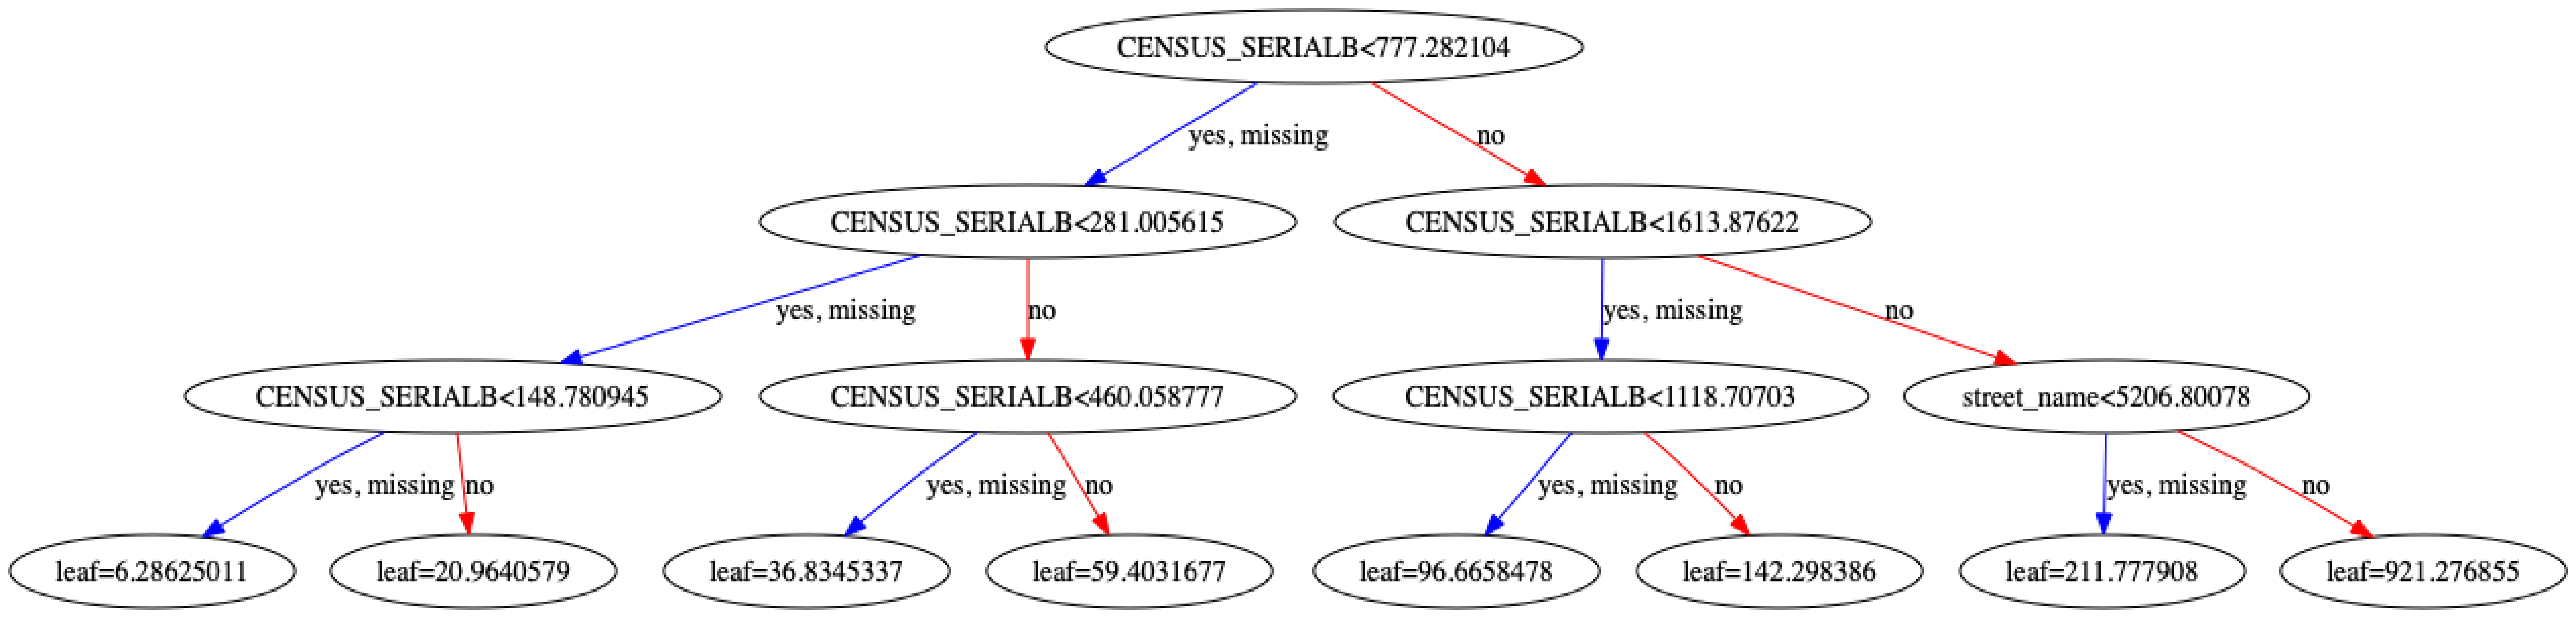

In [12]:
plot_tree(model_gboost.named_steps["regressor"])
fig = plt.gcf()
fig.set_size_inches(150, 100)
plt.show()

In [13]:
# Let's try with just training with just 1850 data
train_X_1850, test_X_1850, train_y_1850, test_y_1850 = train_test_split(census_1850_model.dropna(subset = ["house_number"]).loc[:,cols], census_1850_model.dropna(subset = ["house_number"]).loc[:,"house_number"])
model_gboost_1850 = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB","WARD_NUM","street_name", "sequence_id", "block_num"])),
                            ('regressor', XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1,
                max_depth = 3, n_estimators = 800, colsample_bytree = 0.6, alpha = 1.5))])

In [14]:
model_gboost_1850.fit(train_X_1850, train_y_1850)
print("Training Score:", model_gboost_1850.score(train_X_1850, train_y_1850))
print("1880 Test Score:", model_gboost_1850.score(test_1880_X, test_1880_y))
print("1850 Test Score:", model_gboost_1850.score(test_X_1850, test_y_1850))

Training Score: 0.9937691128543146
1880 Test Score: -0.17437369612858955
1850 Test Score: 0.9804104010427452


In [15]:
print("1850 Dwelling Score:", model_gboost_1850.score(dwellings_1850.dropna(subset=["house_number"]).loc[:, cols], dwellings_1850.dropna(subset=["house_number"]).loc[:,"house_number"]))

1850 Dwelling Score: 0.9805634684211533


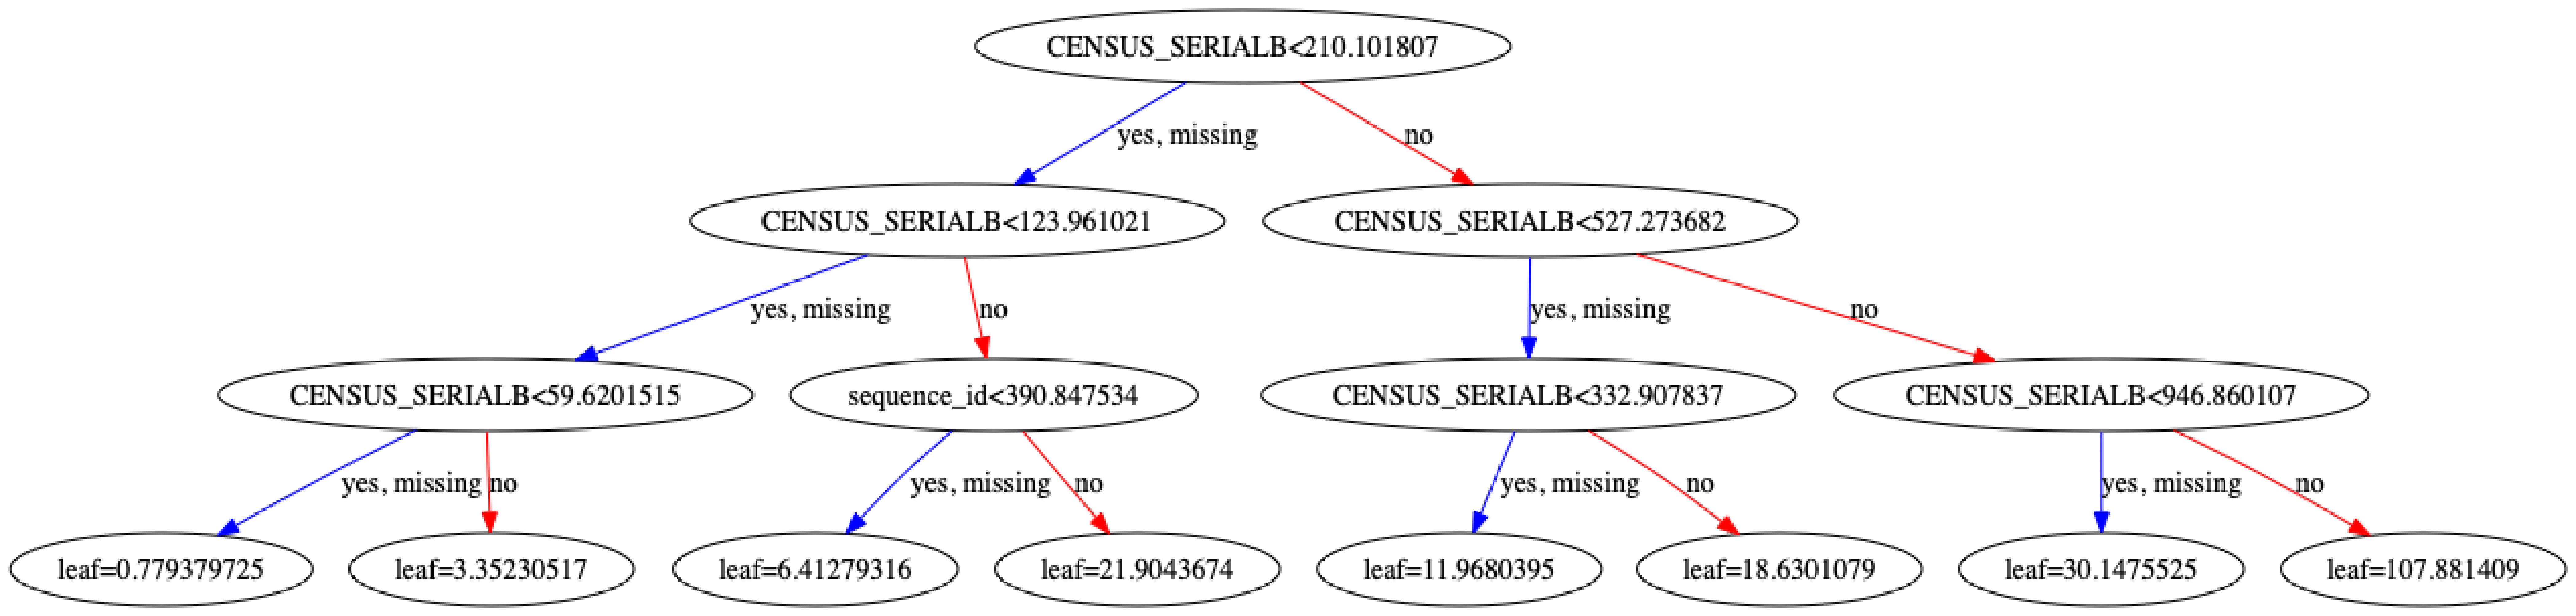

In [16]:
plot_tree(model_gboost_1850.named_steps["regressor"], num_trees = 8)
fig = plt.gcf()
fig.set_size_inches(150, 100)
plt.show()

In [17]:
#Let's try training the linear model with just the 1850 data
lin_mod = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB","WARD_NUM","street_name", "sequence_id", "block_num"])),
                    ('regressor', LinearRegression())])
lin_mod.fit(train_X_1850.fillna("None"), train_y_1850)
print("Training Score:", lin_mod.score(train_X_1850.fillna("None"), train_y_1850))
print("1880 Test Score:", lin_mod.score(test_1880_X.fillna("None"), test_1880_y))
print("1850 Test Score:", lin_mod.score(test_X_1850.fillna("None"), test_y_1850))

Training Score: 0.9581612111968403
1880 Test Score: -0.18393501350471664
1850 Test Score: 0.9077371683651171


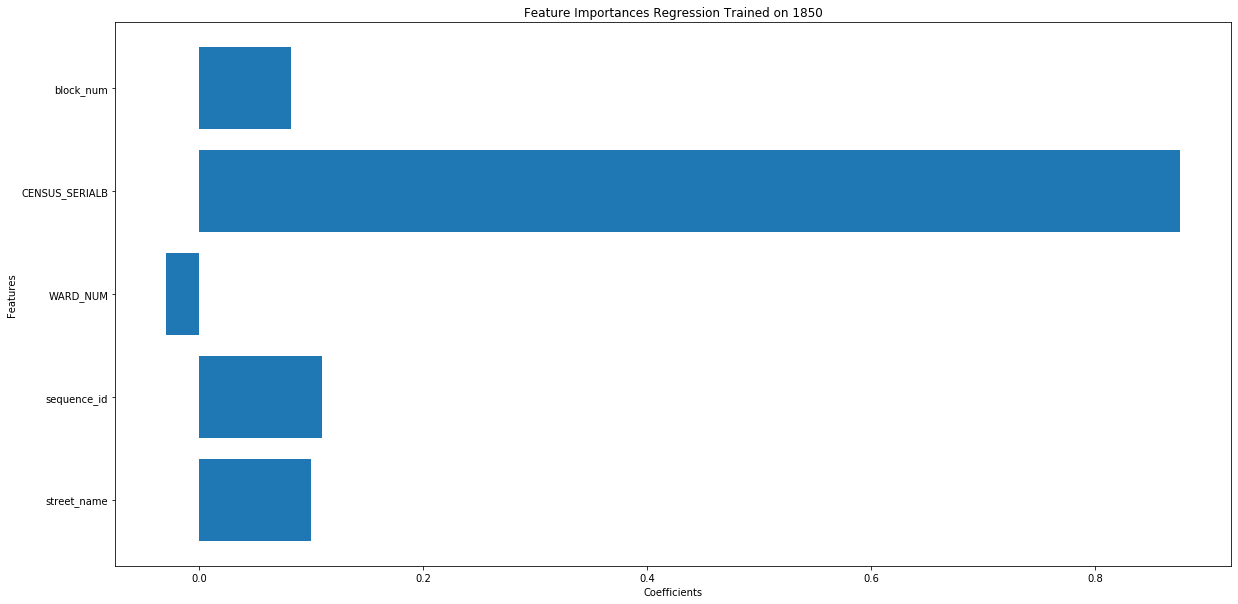

In [18]:
interpolation.graph_coefs(lin_mod.named_steps['preprocess'].get_feature_names(), lin_mod.named_steps['regressor'].coef_, "Feature Importances Regression Trained on 1850")

### Investigate SerialB Importance

In [19]:
cols = ["street_name", "sequence_id", "WARD_NUM", "block_num", "sequence_order"]
train_X, train_y, test_1880_X, test_1880_y, test_1850_X, test_1850_y = interpolation.create_train_test_data(census_1880_model, census_1850_model, cols)

In [20]:
model_gboost_noB = Pipeline([('preprocess', TargetEncoder(cols = cols)),
                            ('regressor', XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1,
                max_depth = 3, n_estimators = 800, colsample_bytree = 0.6, alpha = 1.5))])

In [21]:
model_gboost_noB.fit(train_X, train_y)
print("Training Score:", model_gboost_noB.score(train_X, train_y))
print("1880 Test Score:", model_gboost_noB.score(test_1880_X, test_1880_y))
print("1850 Test Score:", model_gboost_noB.score(test_1850_X, test_1850_y))

Training Score: 0.9635943576566758
1880 Test Score: 0.9675414282537227
1850 Test Score: 0.8520772211107956


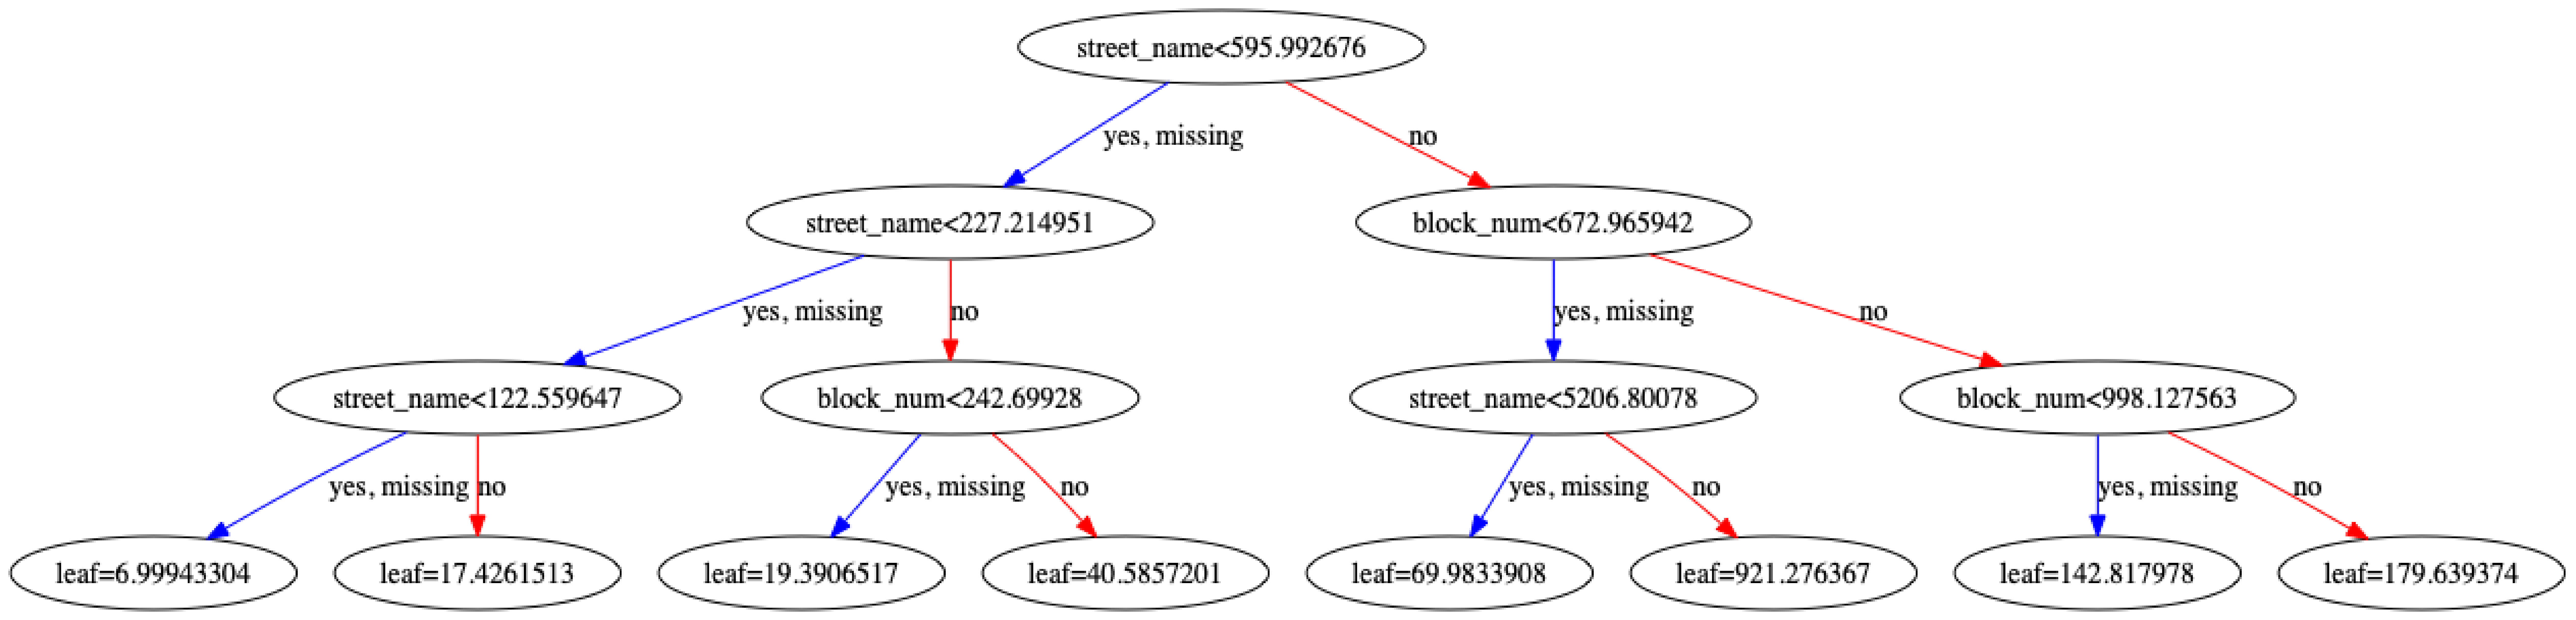

In [22]:
plot_tree(model_gboost_noB.named_steps["regressor"])
fig = plt.gcf()
fig.set_size_inches(150, 100)
plt.show()

In [23]:
#let's do it at the dwelling level (ei: maybe serialB is helping with dealing with duplicates?)
cols = ["street_name", "sequence_id", "WARD_NUM", "block_num", "sequence_order"]
train_X, train_y, test_1880_X, test_1880_y, test_1850_X, test_1850_y = interpolation.create_train_test_data(dwellings_1880, dwellings_1850, cols)

In [24]:
model_gboost_dwell = Pipeline([('preprocess', TargetEncoder(cols = cols)),
                            ('regressor', XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1,
                max_depth = 3, n_estimators = 800, colsample_bytree = 0.6, alpha = 1.5))])

In [25]:
model_gboost_dwell.fit(train_X, train_y)
print("Training Score:", model_gboost_dwell.score(train_X, train_y))
print("1880 Test Score:", model_gboost_dwell.score(test_1880_X, test_1880_y))
print("1850 Test Score:", model_gboost_dwell.score(test_1850_X, test_1850_y))

Training Score: 0.9650635033319362
1880 Test Score: 0.9623443931250656
1850 Test Score: 0.5003441226876302


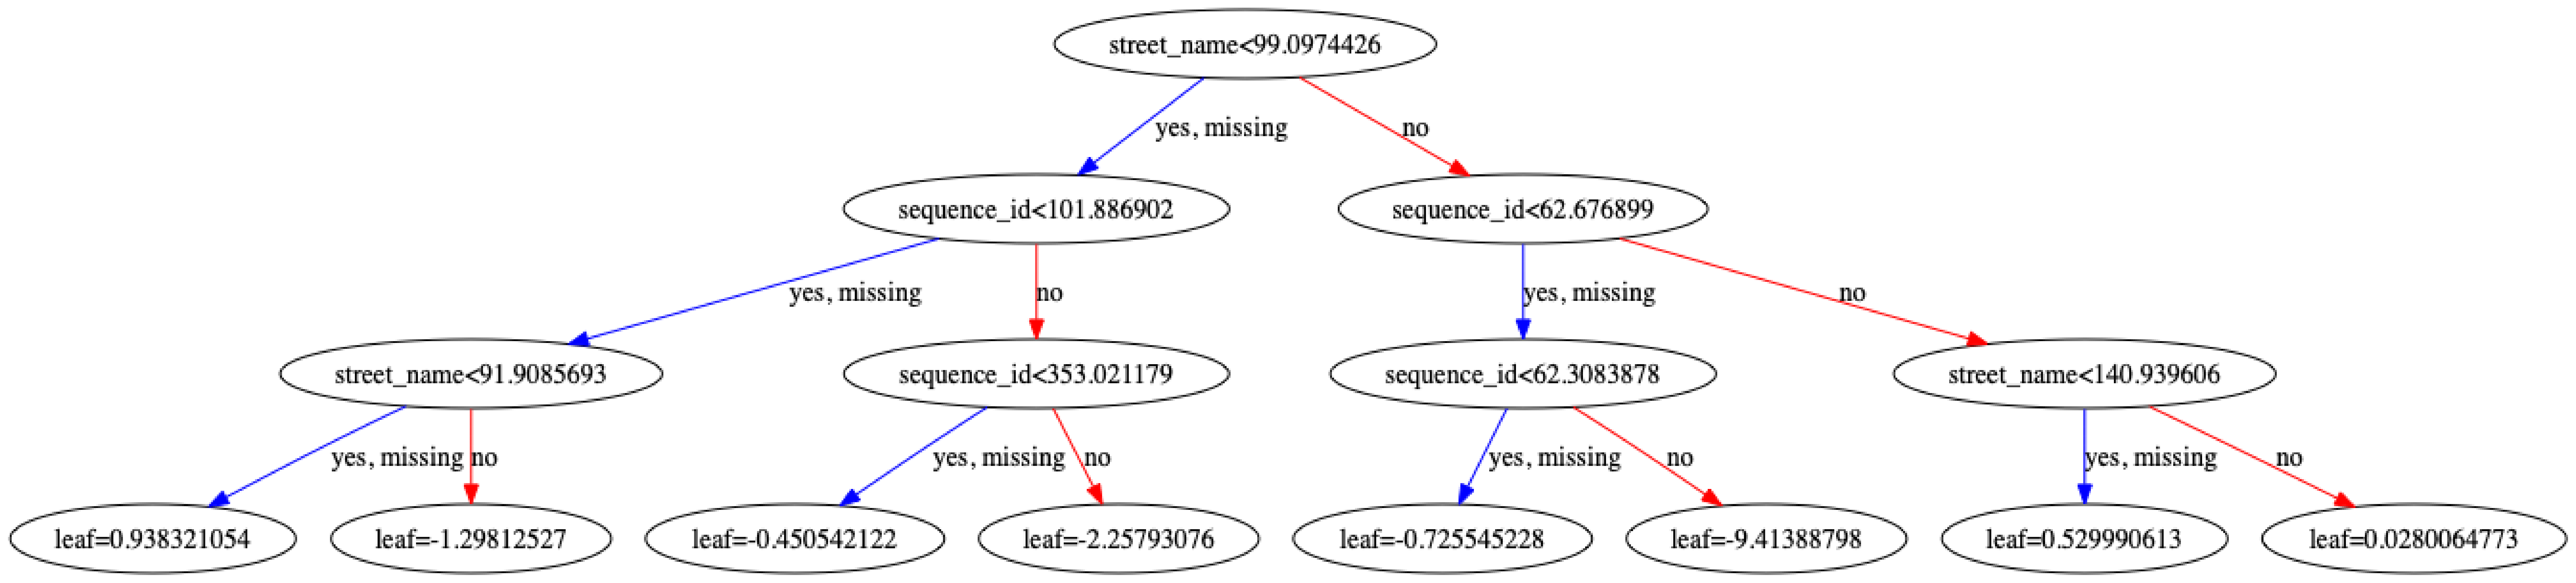

In [26]:
plot_tree(model_gboost_dwell.named_steps["regressor"], num_trees = 500)
fig = plt.gcf()
fig.set_size_inches(150, 100)
plt.show()

### Let's Try to Get a Sense of How This Works On Our Use Case

#### First we need to create a dataset where we are reasonably sure of what the street names are

In [27]:
census_1850_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 514718 entries, 0 to 514717
Data columns (total 37 columns):
block_num                  261427 non-null float64
CD_ADDRESS                 261427 non-null object
CD_X                       261427 non-null float64
CD_Y                       261427 non-null float64
CENSUS_AGE                 514718 non-null int64
CENSUS_CITY                514718 non-null int64
CENSUS_DWELLING_NUM        514718 non-null float64
CENSUS_DWELLING_SEQ        513135 non-null float64
CENSUS_DWELLING_SIZE       514718 non-null int64
CENSUS_GEOG                514006 non-null object
CENSUS_HH_NUM              514718 non-null int64
CENSUS_ID                  12315 non-null object
CENSUS_IMPREL              514718 non-null int64
CENSUS_INDEX               514718 non-null int64
CENSUS_IPUMS_UID           514718 non-null object
CENSUS_LABFORCE            514718 non-null int64
CENSUS_LINE                514718 non-null int64
CENSUS_MARST               514718 non-null 

In [28]:
dwellings_1850["street_name_next"] = dwellings_1850["street_name"].shift(-1)
dwellings_1850_predict = dwellings_1850[dwellings_1850["street_name_next"] == dwellings_1850["street_name"]]

In [29]:
print("Range of dwellings between records with known consecutive streets:", min(dwellings_1850_predict.num_between), "-", max(dwellings_1850_predict.num_between))

Range of dwellings between records with known consecutive streets: 1.0 - 19.0


In [30]:
dwellings_1850.head(10)

,WARD_NUM,CENSUS_DWELLING_NUM,block_num,CD_ADDRESS,CD_X,CD_Y,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,...,next_y,dist,num_between,sequence_id,sequence_len,sequence_order,house_number,street_name,predicted_house_number,street_name_next
0,1.0,1.0,3794.0,37 South,-74.008250,40.703128,49.0,4610.0,1.0,84.0,...,40.707284,0.088400,3.0,5.0,6.0,3.0,37.0,South,13.456789,Liberty
1,1.0,4.0,713.0,76 Liberty,-74.007679,40.707284,23.0,4610.0,4.0,1.0,...,40.707572,0.096077,2.0,5.0,6.0,5.0,76.0,Liberty,17.966019,Cedar
2,1.0,6.0,709.0,46 Cedar,-74.009067,40.707572,25.0,4610.0,6.0,3.0,...,40.709673,0.189482,1.0,5.0,6.0,6.0,46.0,Cedar,58.770195,Liberty |
3,1.0,7.0,682.0,102 Liberty |,-74.011747,40.709673,22.0,4610.0,7.0,1.0,...,40.705869,0.290189,2.0,6.0,2.0,2.0,102.0,Liberty |,104.939690,Pearl
4,1.0,9.0,718.0,163 Pearl,-74.007680,40.705869,22.0,4610.0,9.0,1.0,...,40.707772,0.123281,12.0,21.0,19.0,12.0,163.0,Pearl,149.835754,Cedar
5,1.0,21.0,709.0,58 Cedar,-74.009386,40.707772,26.0,4610.0,21.0,3.0,...,40.706125,0.046379,1.0,21.0,19.0,13.0,58.0,Cedar,-2.261429,Wall
6,1.0,22.0,718.0,54 Wall,-74.008891,40.706125,30.0,4610.0,22.0,1.0,...,40.709040,0.169758,6.0,21.0,19.0,19.0,54.0,Wall,28.966728,Cedar
7,1.0,28.0,680.0,95 Cedar,-74.011213,40.709040,21.0,4610.0,28.0,3.0,...,40.709066,0.005536,1.0,28.0,2.0,1.0,95.0,Cedar,76.882866,Cedar
8,1.0,29.0,680.0,97 Cedar,-74.011293,40.709066,32.0,4610.0,29.0,2.0,...,40.707039,0.224711,1.0,28.0,2.0,2.0,97.0,Cedar,76.882866,Cedar
9,1.0,30.0,713.0,23 Cedar,-74.008089,40.707039,26.0,4610.0,30.0,4.0,...,40.706761,0.147859,9.0,38.0,11.0,9.0,23.0,Cedar,58.574329,Wall


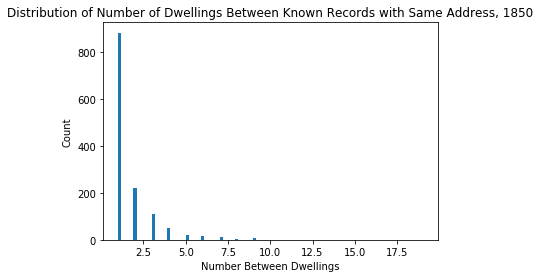

In [31]:
plt.hist(dwellings_1850_predict["num_between"], bins = "auto")
plt.title("Distribution of Number of Dwellings Between Known Records on Same Street, 1850")
plt.xlabel("Number Between Dwellings")
plt.ylabel("Count")
plt.show()

In [32]:
# Let's use 10 as a limit for what to fill in
dwellings_1850_predict_lim = dwellings_1850_predict[dwellings_1850_predict["num_between"] <= 5].copy()
total_to_fill = dwellings_1850_predict_lim[["num_between"]].sum()
print("Total dwellings we can fill in based on this:", total_to_fill - len(dwellings_1850_predict_lim))

Total dwellings we can fill in based on this: num_between    668.0
dtype: float64


In [33]:
print("This will increase the number of dwellings we know of by:", (total_to_fill - len(dwellings_1850_predict_lim))/filled_1850.groupby(["WARD_NUM", "CENSUS_DWELLING_NUM"]).ngroups)

This will increase the number of dwellings we know of by: num_between    0.033695
dtype: float64


So this won't really improve the dwelling match rate that much (from 0.38 to 0.41) but hopefully it'll and provide validation that this approach is working. Then once we can work on street prediction, we can apply this process again to get good matches.

In [34]:
#So what I really want is the dataset of values in between
#Well, I guess we don't really need to drop these, we can just predict them too...
dwellings_1850_predict_lim.reset_index(drop = True).head()

,WARD_NUM,CENSUS_DWELLING_NUM,block_num,CD_ADDRESS,CD_X,CD_Y,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,...,next_y,dist,num_between,sequence_id,sequence_len,sequence_order,house_number,street_name,predicted_house_number,street_name_next
0,1.0,28.0,680.0,95 Cedar,-74.011213,40.709040,21.0,4610.0,28.0,3.0,...,40.709066,0.005536,1.0,28.0,2.0,1.0,95.0,Cedar,76.882866,Cedar
1,1.0,29.0,680.0,97 Cedar,-74.011293,40.709066,32.0,4610.0,29.0,2.0,...,40.707039,0.224711,1.0,28.0,2.0,2.0,97.0,Cedar,76.882866,Cedar
2,1.0,51.0,716.0,35 Wall,-74.010104,40.706670,30.0,4610.0,51.0,1.0,...,40.707407,0.060636,1.0,52.0,3.0,1.0,35.0,Wall,-58.872620,Wall
3,1.0,54.0,715.0,38 Wall,-74.009943,40.706758,65.0,4610.0,65.0,5.0,...,40.706860,0.029176,1.0,56.0,5.0,1.0,38.0,Wall,34.921089,Wall
4,1.0,79.0,3797.0,6 Stone,-74.012503,40.704005,35.0,4610.0,186.0,6.0,...,40.704005,0.000000,1.0,81.0,7.0,4.0,6.0,Stone,12.435987,Stone


In [35]:
#Let's add an indicator column for known addresses 
dwellings_1850_predict_lim["Known"] = 1

In [36]:
#Let's try predicting on dwellings, since we saw that doing that
#seemed to work fine when tested
dwellings_1850_noad = filled_1850.groupby(["WARD_NUM", "CENSUS_DWELLING_NUM"], as_index = False).first()
prediction_data_1850 = interpolation.dwellings_to_all(dwellings_1850_noad, dwellings_1850_predict_lim, ["WARD_NUM", "CENSUS_DWELLING_NUM","sequence_order","sequence_id", "house_number", "street_name", "street_name_next", "Known"], ["WARD_NUM", "CENSUS_DWELLING_NUM"])
prediction_data_1850.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19825 entries, 0 to 19824
Data columns (total 38 columns):
WARD_NUM                   19825 non-null int64
CENSUS_DWELLING_NUM        19825 non-null float64
block_num                  7524 non-null float64
CD_ADDRESS                 7524 non-null object
CD_X                       7524 non-null float64
CD_Y                       7524 non-null float64
CENSUS_AGE                 19825 non-null int64
CENSUS_CITY                19825 non-null int64
CENSUS_DWELLING_SEQ        19812 non-null float64
CENSUS_DWELLING_SIZE       19825 non-null int64
CENSUS_GEOG                19817 non-null object
CENSUS_HH_NUM              19825 non-null int64
CENSUS_ID                  7524 non-null object
CENSUS_IMPREL              19825 non-null int64
CENSUS_INDEX               19825 non-null int64
CENSUS_IPUMS_UID           19825 non-null object
CENSUS_LABFORCE            19825 non-null int64
CENSUS_LINE                19825 non-null int64
CENSUS_MARST      

In [37]:
prediction_data_1850.iloc[120:150]

,WARD_NUM,CENSUS_DWELLING_NUM,block_num,CD_ADDRESS,CD_X,CD_Y,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,...,CENSUS_SEX,selected,spatial_weight,spatial_weight_sum,sequence_order,sequence_id,house_number,street_name,street_name_next,Known
120,1,121.0,NaN,NaN,NaN,NaN,30,4610,402.0,3,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
121,1,122.0,687.0,135 Water,-74.006682,40.705701,37,4610,406.0,10,...,1,1.0,1.90,1.90,NaN,NaN,NaN,NaN,NaN,NaN
122,1,123.0,NaN,NaN,NaN,NaN,69,4610,407.0,11,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123,1,124.0,707.0,61 South,-74.005969,40.704551,48,4610,408.0,2,...,1,1.0,1.87,1.87,NaN,NaN,NaN,NaN,NaN,NaN
124,1,125.0,NaN,NaN,NaN,NaN,26,4610,410.0,1,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125,1,126.0,3780.0,51 Whitehall,-74.012281,40.702543,45,4610,411.0,5,...,1,1.0,2.00,2.00,2.0,129.0,51.0,Whitehall,Whitehall,1.0
126,1,127.0,NaN,NaN,NaN,NaN,24,4610,413.0,4,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,1,128.0,649.0,26 Whitehall,-74.013199,40.703331,34,4610,414.0,7,...,1,1.0,2.00,2.00,NaN,NaN,NaN,NaN,NaN,NaN
128,1,129.0,NaN,NaN,NaN,NaN,50,4610,417.0,3,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129,1,130.0,3788.0,24 Moore,-74.012095,40.702196,36,4610,420.0,7,...,2,1.0,2.00,2.00,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
#first I need to get street_names for predictions
interpolation.create_street_house(prediction_data_1850, "CD_ADDRESS")

dataframes = []
find = None
for row in prediction_data_1850.itertuples():
    if row.Known == 1:
        index_start = row.Index
        find = row.street_name_next
    
    elif find is not None and find == row.street_name:
        index_end = row.Index + 1
        dataframes.append(prediction_data_1850.iloc[index_start:index_end])
        find = None
        
prediction_1850_p2 = pd.concat(dataframes)

In [42]:
prediction_1850_p2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2087 entries, 28 to 17970
Data columns (total 38 columns):
WARD_NUM                   2087 non-null int64
CENSUS_DWELLING_NUM        2087 non-null float64
block_num                  2087 non-null float64
CD_ADDRESS                 1634 non-null object
CD_X                       1634 non-null float64
CD_Y                       1634 non-null float64
CENSUS_AGE                 2087 non-null int64
CENSUS_CITY                2087 non-null int64
CENSUS_DWELLING_SEQ        2087 non-null float64
CENSUS_DWELLING_SIZE       2087 non-null int64
CENSUS_GEOG                2087 non-null object
CENSUS_HH_NUM              2087 non-null int64
CENSUS_ID                  1634 non-null object
CENSUS_IMPREL              2087 non-null int64
CENSUS_INDEX               2087 non-null int64
CENSUS_IPUMS_UID           2087 non-null object
CENSUS_LABFORCE            2087 non-null int64
CENSUS_LINE                2087 non-null int64
CENSUS_MARST               2087

In [39]:
prediction_1850_p2["Known"] = prediction_1850_p2.apply(lambda x: 0 if x["street_name"] is None else 1, axis = 1)

In [40]:
prediction_1850_p2[["sequence_id", "street_name", "block_num"]] = prediction_1850_p2[["sequence_id", "street_name", "block_num"]].ffill()
prediction_1850_p2.head(20)

,WARD_NUM,CENSUS_DWELLING_NUM,block_num,CD_ADDRESS,CD_X,CD_Y,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,...,CENSUS_SEX,selected,spatial_weight,spatial_weight_sum,sequence_order,sequence_id,house_number,street_name,street_name_next,Known
28,1,29.0,680.0,97 Cedar,-74.011293,40.709066,32,4610,29.0,2,...,1,1.0,1.90,3.77,2.0,28.0,97.0,Cedar,Cedar,1
29,1,30.0,713.0,23 Cedar,-74.008089,40.707039,26,4610,30.0,4,...,1,1.0,2.00,2.00,NaN,28.0,23.0,Cedar,NaN,1
50,1,51.0,716.0,35 Wall,-74.010104,40.706670,30,4610,51.0,1,...,1,1.0,1.82,1.82,1.0,52.0,35.0,Wall,Wall,1
51,1,52.0,711.0,16 Wall,-74.010958,40.707407,38,4610,52.0,35,...,1,1.0,1.35,1.35,NaN,52.0,16.0,Wall,NaN,1
53,1,54.0,715.0,38 Wall,-74.009943,40.706758,65,4610,65.0,5,...,2,1.0,2.00,2.00,1.0,56.0,38.0,Wall,Wall,1
54,1,55.0,716.0,27 Wall,-74.010365,40.706860,35,4610,70.0,4,...,1,1.0,2.00,2.00,NaN,56.0,27.0,Wall,NaN,1
79,1,80.0,3797.0,6 Stone,-74.012503,40.704005,40,4610,190.0,2,...,1,1.0,1.90,1.90,5.0,81.0,6.0,Stone,Stone,1
80,1,81.0,3797.0,4 Stone,-74.012590,40.704004,30,4610,194.0,5,...,2,1.0,1.90,1.90,NaN,81.0,4.0,Stone,NaN,1
125,1,126.0,3780.0,51 Whitehall,-74.012281,40.702543,45,4610,411.0,5,...,1,1.0,2.00,2.00,2.0,129.0,51.0,Whitehall,Whitehall,1
126,1,127.0,3780.0,NaN,NaN,NaN,24,4610,413.0,4,...,1,NaN,NaN,NaN,NaN,129.0,NaN,Whitehall,NaN,0


In [43]:
prediction_1850_p2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2087 entries, 28 to 17970
Data columns (total 38 columns):
WARD_NUM                   2087 non-null int64
CENSUS_DWELLING_NUM        2087 non-null float64
block_num                  2087 non-null float64
CD_ADDRESS                 1634 non-null object
CD_X                       1634 non-null float64
CD_Y                       1634 non-null float64
CENSUS_AGE                 2087 non-null int64
CENSUS_CITY                2087 non-null int64
CENSUS_DWELLING_SEQ        2087 non-null float64
CENSUS_DWELLING_SIZE       2087 non-null int64
CENSUS_GEOG                2087 non-null object
CENSUS_HH_NUM              2087 non-null int64
CENSUS_ID                  1634 non-null object
CENSUS_IMPREL              2087 non-null int64
CENSUS_INDEX               2087 non-null int64
CENSUS_IPUMS_UID           2087 non-null object
CENSUS_LABFORCE            2087 non-null int64
CENSUS_LINE                2087 non-null int64
CENSUS_MARST               2087

In [44]:
prediction_1850_p2["predict_house_num"] = model_gboost.predict(prediction_1850_p2.loc[:,cols])

KeyError: 'CENSUS_SERIALB'

In [ ]:
cols

In [ ]:
prediction_1850_p2.iloc[30:60]